# A few geostatistical concepts

To attempt to cover geostatistics in any depth in roughly one hour would be impossible. Thus, I plan to introduce a few concepts you may find useful below and we'll see how much we can cover. These may be fairly basic geostatistical examples, but hopefully the provide some general sense of how Python can be used for statistical analyses. The concepts we will cover (briefly) are:

- Least squares regressions (with and without weighting)
- Linear correlation
- Goodness-of-fit tests
- Monte Carlo inversion

## Some data

For this exercise we can work with some hastily compiled climate data from a [global climate database](https://www.weatherbase.com/weather/countryall.php3). I've taken annual average, minimum, and maximum for 10 cities and put the data into [a csv file](data/global-climate-data.csv) that we can load and explore using the geostatistical concepts below. The 10 cities are largely from the northern hemisphere, and the goal here is to test the hypothesis that average annual temperatueres vary strongly as a function of latitude of the cities (a bold hypothesis, I know).

Let's start by loading the data using pandas.

In [1]:
import pandas as pd

# Read data file
fp = "data/global-climate-data.csv"
data = pd.read_csv(fp)

In [2]:
data

,City,Latitude,Average temperature,Min temperature,Max temperature
0,Helsinki,60.19,5.0,1.0,8.0
1,Paris,48.44,12.4,8.8,16.0
2,Athens,37.54,18.5,14.3,22.0
3,Cairo,31.24,21.0,16.0,27.0
4,Chennai,13.00,28.5,24.2,32.9
5,Kuala Lumpur,3.07,27.0,23.0,31.0
6,Quito,-0.09,14.0,10.0,19.0
7,Guayaquil,-2.09,26.0,22.0,30.0
8,Ivalo,68.36,1.0,-5.0,2.0
9,Kathmandu,27.42,18.0,13.0,22.0


In [3]:
# Calculate "deviation" by dividing difference between min and max temperatures by 2
data["Deviation"] = (data["Max temperature"] - data["Min temperature"]) / 2.0

In [4]:
# Check DataFrame contents
data

,City,Latitude,Average temperature,Min temperature,Max temperature,Deviation
0,Helsinki,60.19,5.0,1.0,8.0,3.50
1,Paris,48.44,12.4,8.8,16.0,3.60
2,Athens,37.54,18.5,14.3,22.0,3.85
3,Cairo,31.24,21.0,16.0,27.0,5.50
4,Chennai,13.00,28.5,24.2,32.9,4.35
5,Kuala Lumpur,3.07,27.0,23.0,31.0,4.00
6,Quito,-0.09,14.0,10.0,19.0,4.50
7,Guayaquil,-2.09,26.0,22.0,30.0,4.00
8,Ivalo,68.36,1.0,-5.0,2.0,3.50
9,Kathmandu,27.42,18.0,13.0,22.0,4.50


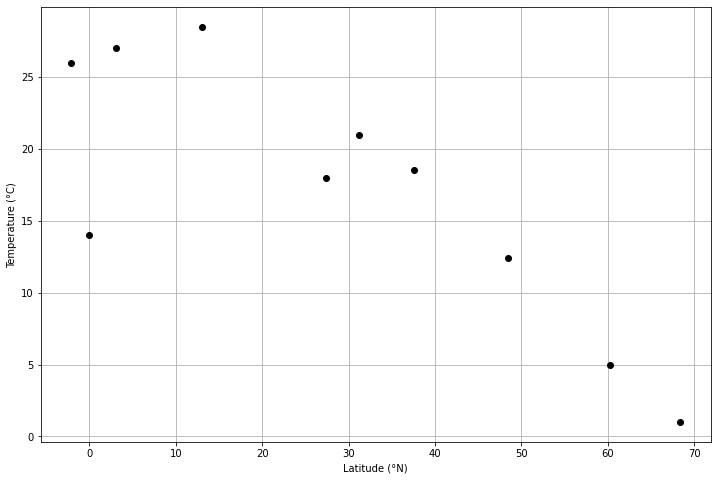

In [5]:
# Create a scatter plot of the average temperatures as a function of latitude
import matplotlib.pyplot as plt

# Create figure, axes
fig, ax = plt.subplots(1, 1, figsize=(12,8))

# Plot temperature data
ax.plot(data["Latitude"], data["Average temperature"], 'ko')

# Add axis labels
ax.set_xlabel("Latitude (°N)")
ax.set_ylabel("Temperature (°C)")

# Enable plot grid
ax.grid()

## Least squares regressions

Least squares regressions can be used to fit a function to a scattered set of data points on an x-y plot. Typically we are fitting a line to the data, so we will use that example here as well.

### Unweighted least squares regressions

We can start with the idea that we want a line that fits a scattered set of x and y points. As you may recall, the equation for a line is

$$
\large
y = A + B x.
$$

Thus, to plot the line we would need to be able to find a slope $B$ and y-intercept $A$. We can find those values from our scatted x and y points using the following:

$$
\large
A = \frac{\sum{x^{2}} \sum{y} - \sum{x} \sum{xy}}{\Delta}
$$

where $x$ is the $i$th data point plotted on the $x$-axis, $y$ is the $i$th data point plotted on the $y$-axis, and $\Delta$ is defined below.

The line slope can be found using

$$
\large
B = \frac{N \sum{xy} - \sum{x} \sum {y}}{\Delta}
$$

where $N$ is the number of values in the regression.

And the value of $\Delta$ is

$$
\large
\Delta = N \sum{x^{2}} - \left( \sum{x} \right)^{2}
$$

Let's test this out for a set of x and y points below.

In [6]:
def calculate_delta(x_values):
    """Calculates divisor term for slope and intercept equations"""
    x_squared_sum = (x_values * x_values).sum()
    x_sum_squared = x_values.sum()**2
    delta = len(x_values) * x_squared_sum - x_sum_squared
    return delta

def calculate_a(x_values, y_values):
    """Calcuates y-intercept for regression line"""
    left_side = (x_values * x_values).sum() * y_values.sum()
    right_side = x_values.sum() * (x_values * y_values).sum()
    delta = calculate_delta(x_values)
    a = (left_side - right_side) / delta
    return a
    
def calculate_b(x_values, y_values):
    """Calculates slope for regression line"""
    left_side = len(x_values) * (x_values * y_values).sum()
    right_side = x_values.sum() * y_values.sum()
    delta = calculate_delta(x_values)
    b = (left_side - right_side) / delta
    return b

In [7]:
# Calculate slope and intercept
a = calculate_a(data["Latitude"].values, data["Average temperature"].values)
b = calculate_b(data["Latitude"].values, data["Average temperature"].values)

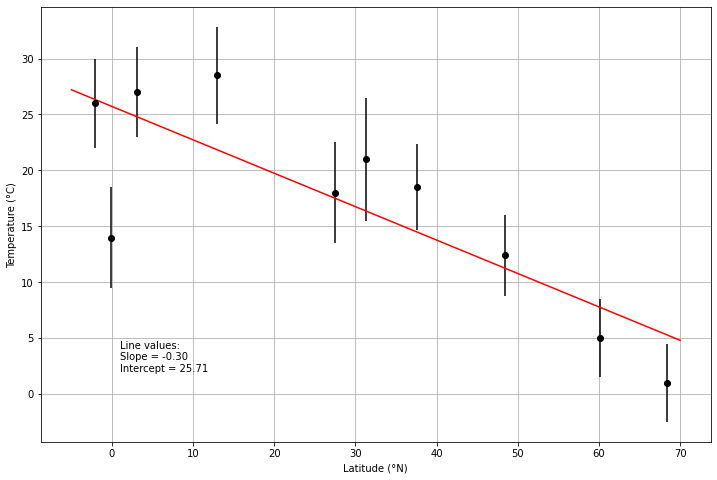

In [8]:
# Plot results
fig, ax = plt.subplots(1, 1, figsize=(12,8))

# Use ax.errorbar rather than ax.plot to show temperature deviations
ax.errorbar(data["Latitude"], data["Average temperature"], fmt='ko', yerr=data["Deviation"])

# Calculate regression line points
x1 = -5.0        # Minimum latitude
x2 = 70.0        # Maximum latitude
y1 = a + b * x1
y2 = a + b * x2

# Plot regression line in red
ax.plot([x1, x2], [y1, y2], 'r-')

# Add axis labels
ax.set_xlabel("Latitude (°N)")
ax.set_ylabel("Temperature (°C)")

# Add text with regression line info
ax.text(1, 2, f"Line values:\nSlope = {b:.2f}\nIntercept = {a:.2f}")

# Enable plot grid
ax.grid()

### Weighted least squares regressions

Let's now imagine a case where the values on the y-axis have some nominal uncertainties $\sigma$. We can modify our regression to include the uncertainties as weights for the point that are inversely proportional to the uncertainty:

$$
\large
w_{i} = 1 / \sigma_{i}^{2}
$$

where $i$ is the ith weight for the ith uncertainty.

We can thus modify our slope and intercept calculations above as follows:

$$
\large
A_{\mathrm{w}} = \frac{\sum{wx^{2}} \sum{wy} - \sum{wx} \sum{wxy}}{\Delta_{\mathrm{w}}},
$$

$$
\large
B_{\mathrm{w}} = \frac{\sum{w} \sum{wxy} - \sum{wx} \sum {wy}}{\Delta_{\mathrm{w}}},
$$

and 

$$
\large
\Delta_{\mathrm{w}} = \sum{w} \sum{wx^{2}} - \left( \sum{wx} \right)^{2}.
$$

Let's consider another example below.

In [9]:
def calculate_deltaw(x_values, w_values):
    """Calculates divisor term for weighted slope and intercept equations"""
    x_squared_sum = (w_values * x_values * x_values).sum()
    x_sum_squared = (w_values * x_values).sum()**2
    delta = w_values.sum() * x_squared_sum - x_sum_squared
    return delta

def calculate_aw(x_values, y_values, w_values):
    """Calcuates y-intercept for weighted regression line"""
    left_side = (w_values * x_values * x_values).sum() * (w_values * y_values).sum()
    right_side = (w_values * x_values).sum() * (w_values * x_values * y_values).sum()
    delta = calculate_deltaw(x_values, w_values)
    a = (left_side - right_side) / delta
    return a
    
def calculate_bw(x_values, y_values, w_values):
    """Calculates slope for weighted regression line"""
    left_side = w_values.sum() * (w_values * x_values * y_values).sum()
    right_side = (w_values * x_values).sum() * (w_values * y_values).sum()
    delta = calculate_deltaw(x_values, w_values)
    b = (left_side - right_side) / delta
    return b

In [10]:
# Modify the deviation for Quito to give it more weight in the regression line calculation
data.loc[(6, "Deviation")] = 0.5

In [11]:
# Calculate weights as 1 over the deviation squared
data["Weight"] = 1 / data["Deviation"]**2

# Check DataFrame contents
data

,City,Latitude,Average temperature,Min temperature,Max temperature,Deviation,Weight
0,Helsinki,60.19,5.0,1.0,8.0,3.50,0.081633
1,Paris,48.44,12.4,8.8,16.0,3.60,0.077160
2,Athens,37.54,18.5,14.3,22.0,3.85,0.067465
3,Cairo,31.24,21.0,16.0,27.0,5.50,0.033058
4,Chennai,13.00,28.5,24.2,32.9,4.35,0.052847
5,Kuala Lumpur,3.07,27.0,23.0,31.0,4.00,0.062500
6,Quito,-0.09,14.0,10.0,19.0,0.50,4.000000
7,Guayaquil,-2.09,26.0,22.0,30.0,4.00,0.062500
8,Ivalo,68.36,1.0,-5.0,2.0,3.50,0.081633
9,Kathmandu,27.42,18.0,13.0,22.0,4.50,0.049383


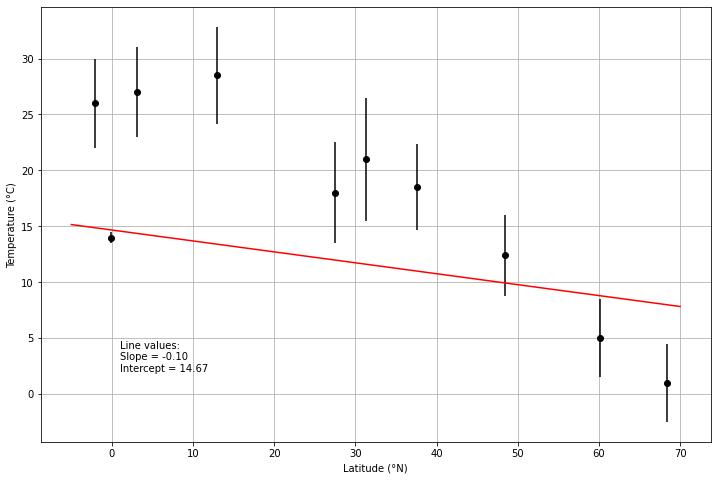

In [12]:
# Calculate weighted slope and intercept
aw = calculate_aw(data["Latitude"].values, data["Average temperature"].values, data["Weight"].values)
bw = calculate_bw(data["Latitude"].values, data["Average temperature"].values, data["Weight"].values)

# Create figure and axes
fig, ax = plt.subplots(1, 1, figsize=(12,8))

# Plot average temperatures and deviations as a function of latitude
ax.errorbar(data["Latitude"], data["Average temperature"], fmt='ko', yerr=data["Deviation"])

# Calculate regression line points
x1w = -5.0
x2w = 70.0
y1w = aw + bw * x1
y2w = aw + bw * x2

# Plot weighted regression line
ax.plot([x1w, x2w], [y1w, y2w], 'r-')

# Add axis labels
ax.set_xlabel("Latitude (°N)")
ax.set_ylabel("Temperature (°C)")

# Add regression line info
ax.text(1, 2, f"Line values:\nSlope = {bw:.2f}\nIntercept = {aw:.2f}")

# Enable plot gridlines
ax.grid()

### More information

Additional introductory information about least-squares regressions can be found on the [Introduction to Quantitative Geology course page](https://introqg-site.readthedocs.io/en/latest/notebooks/L2/least-squares.html).

## Linear correlation

The linear correlation coefficient $r$ measures how well a given set of points fit to a line, with values ranging from 1 for a perfect positive correlation to -1 for a perfect negative correlation. For a given set of x and y points, $r$ can be calculated as follows:

$$
\large
r = \frac{\sum{\left(x_{i} - \bar{x} \right)\left(y_{i} - \bar{y} \right)}}{\sqrt{\sum{\left(x_{i} - \bar{x} \right)^2} \sum{\left(y_{i} - \bar{y} \right)^2}}},
$$

where $\bar{x}$ and $\bar{y}$ are the means of the values on the x and y axes, respectively.

In [13]:
# Import NumPy for square root function
import numpy as np

In [14]:
# Rename plot x and y values for simplicity
x = data["Latitude"].values
y = data["Average temperature"].values

In [15]:
# Calculate correlation coefficient
top = ((x - x.mean()) * (y - y.mean())).sum()
bottom = np.sqrt(((x - x.mean())**2).sum() * ((y - y.mean())**2).sum())
r = top / bottom

In [16]:
print(f"Correlation coefficient r: {r:.4f}")

Correlation coefficient r: -0.8181


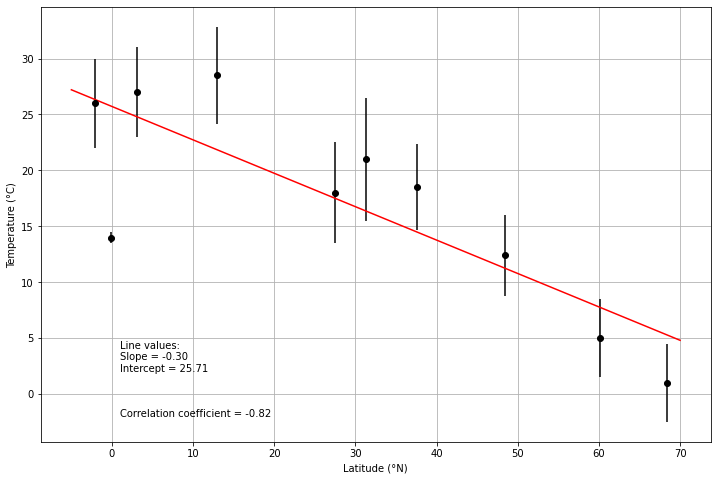

In [17]:
# Create figure and axes
fig, ax = plt.subplots(1, 1, figsize=(12,8))

# Plot average temperatures as a function of latitude (with errorbars)
ax.errorbar(data["Latitude"], data["Average temperature"], fmt='ko', yerr=data["Deviation"])

# Calculate regression line points
# NOTE: Using the unweighted regression line here!
x1 = -5.0
x2 = 70.0
y1 = a + b * x1
y2 = a + b * x2

# Plot unweighted regression line
ax.plot([x1, x2], [y1, y2], 'r-')

# Add axis labels
ax.set_xlabel("Latitude (°N)")
ax.set_ylabel("Temperature (°C)")

# Add text with statistical values
ax.text(1, 2, f"Line values:\nSlope = {b:.2f}\nIntercept = {a:.2f}")
ax.text(1, -2, f"Correlation coefficient = {r:.2f}")

# Enable gridlines
ax.grid()

## Goodness-of-fit tests

Goodness-of-fit tests provide a way to quantify how well predictions fit a given set of observations that have known uncertainties. One common measure is the *weighted sum of the squared errors*, also often refered to simply as chi squared:

$$
\large
\chi^{2} = \sum \frac{(O_{i} - E_{i})^{2}}{\sigma_{i}^{2}}
$$

where $O_{i}$ is the $i$th observed value, $E_{i}$ is the $i$th expected value, and $\sigma_{i}$ is the $i$th standard deviation. For a given observation $i$, this equation will be less than 1 if the prediction falls within the uncertainties of the measurement or greater than 1 otherwise. This is fine, but it can then be confusing when the values are summed. Another option involves dividing by the number of values used in the calculation, as shown below.

$$
\large
\chi^{2} = \frac{1}{N} \sum \frac{(O_{i} - E_{i})^{2}}{\sigma_{i}^{2}}
$$

where $N$ is the number of values in the summation. This results in a $\chi^{2}$ value that should be less than 1 if the predictions are within the uncertainties *on average*, and greater than 1 otherwise.